In [43]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te
import time

In [44]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.simple_sbml import SimpleSBML
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix

from SBMLLint.games.som import SOM
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

In [45]:
os.getcwd()

'/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/notebook'

In [46]:
# Load relevant bigg models
# bigg constants
BIGG_RESULTS = "results"
BIGG_ID = "bigg_id"
BIGG_GENECOUNT = "gene_count"
BIGG_REACTION_COUNT = "reaction_count"
BIGG_ORGANISM = "organism"
BIGG_METABOLITE_COUNT = "metabolite_count"
import requests
res = requests.get('http://bigg.ucsd.edu/api/v2/models')
bigg_models = res.json()[BIGG_RESULTS]
bigg_ids = [bigg[BIGG_ID] for bigg in bigg_models]
bigg_models[:1]

[{'bigg_id': 'e_coli_core',
  'gene_count': 137,
  'reaction_count': 95,
  'organism': 'Escherichia coli str. K-12 substr. MG1655',
  'metabolite_count': 72}]

In [5]:
print("number of BiGG models: %d" % len(bigg_models))
# Check the range of the model size
smallest_bigg = ""
biggest_bigg = ""
current_sm_reactioncount = 100000
current_bg_reactioncount = 0
for big in bigg_models:
  if big[BIGG_REACTION_COUNT] < current_sm_reactioncount:
    smallest_bigg = big[BIGG_ID]
    current_sm_reactioncount = big[BIGG_REACTION_COUNT]
  if big[BIGG_REACTION_COUNT] > current_bg_reactioncount:
    biggest_bigg = big[BIGG_ID]
    current_bg_reactioncount = big[BIGG_REACTION_COUNT]
print("Smallest model is: %s (has %d reactions)" % (smallest_bigg, current_sm_reactioncount))
print("Biggest model is: %s (has %d reactions)" % (biggest_bigg, current_bg_reactioncount))

number of BiGG models: 108
Smallest model is: e_coli_core (has 95 reactions)
Biggest model is: Recon3D (has 10600 reactions)


In [6]:
bigg_df = pd.DataFrame(bigg_models).set_index(BIGG_ID)
bigg_df.sort_values(by=BIGG_REACTION_COUNT, 
                    inplace=True)
bigg_df.head()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
e_coli_core,137,95,Escherichia coli str. K-12 substr. MG1655,72
iAB_RBC_283,346,469,Homo sapiens,342
iIS312,312,519,Trypanosoma cruzi Dm28c,606
iIS312_Amastigote,312,519,Trypanosoma cruzi Dm28c,606
iIS312_Epimastigote,312,519,Trypanosoma cruzi Dm28c,606


In [7]:
bigg_df.tail()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
RECON1,1905,3741,Homo sapiens,2766
iCHOv1_DG44,1184,3942,Cricetulus griseus,2751
iLB1027_lipid,1027,4456,Phaeodactylum tricornutum CCAP 1055/1,2172
iCHOv1,1766,6663,Cricetulus griseus,4456
Recon3D,2248,10600,Homo sapiens,5835


In [8]:
bigg_df.loc['e_coli_core']

gene_count                                                137
reaction_count                                             95
organism            Escherichia coli str. K-12 substr. MG1655
metabolite_count                                           72
Name: e_coli_core, dtype: object

(array([ 1.,  1.,  7.,  5., 11.,  5.,  1.,  1.,  1.,  1.,  3.,  5., 58.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   95. ,   305.1,   515.2,   725.3,   935.4,  1145.5,  1355.6,
         1565.7,  1775.8,  1985.9,  2196. ,  2406.1,  2616.2,  2826.3,
         3036.4,  3246.5,  3456.6,  3666.7,  3876.8,  4086.9,  4297. ,
         4507.1,  4717.2,  4927.3,  5137.4,  5347.5,  5557.6,  5767.7,
         5977.8,  6187.9,  6398. ,  6608.1,  6818.2,  7028.3,  7238.4,
         7448.5,  7658.6,  7868.7,  8078.8,  8288.9,  8499. ,  8709.1,
         8919.2,  9129.3,  9339.4,  9549.5,  9759.6,  9969.7, 10179.8,
        10389.9, 10600. ]),
 <a list of 50 Patch objects>)

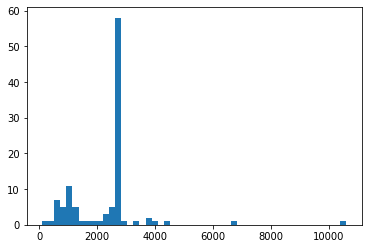

In [9]:
plt.hist(bigg_df[BIGG_REACTION_COUNT], bins=50)

In [10]:
# Download it to BiGG folder - executed so commentized for now
# from urllib.request import urlopen
# for bigg_id in bigg_ids:
#   url_str = "http://bigg.ucsd.edu/static/models/" + bigg_id + ".xml"
#   url_connect = urlopen(url_str)
#   contents = url_connect.read()
#   file = open(os.path.join(cn.BIGG_DIR, bigg_id + ".xml"), 'wb')
#   file.write(contents)
#   file.close()

In [11]:
bigg_file = os.path.join(cn.BIGG_DIR, smallest_bigg+".xml")
bigg_file

'/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/data/bigg/e_coli_core.xml'

In [47]:
bigg_df.tail()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
RECON1,1905,3741,Homo sapiens,2766
iCHOv1_DG44,1184,3942,Cricetulus griseus,2751
iLB1027_lipid,1027,4456,Phaeodactylum tricornutum CCAP 1055/1,2172
iCHOv1,1766,6663,Cricetulus griseus,4456
Recon3D,2248,10600,Homo sapiens,5835


In [12]:
type(bigg_df.index)


pandas.core.indexes.base.Index

In [13]:
# initialization test
EXCEPTIONS = ["iAT_PLT_636",
             "iSynCJ816",
             "iRC1080",
             "iYS1720",
             "iMM1415"]
# count = 0
# for f in bigg_df.index:
#   fpath = os.path.join(cn.BIGG_DIR, f+".xml")
#   count += 1
#   if (count%5)==0:
#     print("Model %s, %d(th) reaction has %d reactions" % (f,
#                                                           count,
#                                                           len(simple.reactions)))
#   try:
#     simple = SimpleSBML()
#     simple.initialize(fpath)
#   except:
#     print("Model %s has issue" % f)
#     EXCEPTIONS.append(f)

In [16]:
MODEL_ID = "model_id"
NUM_TOTAL_REACTIONS = "num_total_reactions"
NUM_BDRY_REACTIONS = "num_bdry_reactions"
NUM_UNIUNI_REACTIONS = "num_uniuni_reactions"
NUM_UMMU_REACTIONS = "num_ummu_reactions"
NUM_MULTIMULTI_REACTIONS = "num_multimulti_reactions"
# Checking all models to calculate number of reactions per type 
count = 0
simple = SimpleSBML()
res_list = []
false_errors = set()
for file in bigg_df.index:
  if file in EXCEPTIONS:
    continue
  num_uniuni = 0
  num_ummu = 0
  num_multimulti = 0
  num_bdry = 0
  count += 1
  if (count%10)==0:
    print("we are analyzing Model number:", count)
  simple.initialize(os.path.join(cn.BIGG_DIR, file+".xml"))
  num_dic = {cn.REACTION_1_1: 0,
             cn.REACTION_1_n: 0,
             cn.REACTION_n_1: 0,
             cn.REACTION_n_n: 0,
             cn.REACTION_BOUNDARY: 0
            }  
  for reaction in simple.reactions:
    for category in num_dic.keys():
      if reaction.category == category:
        num_dic[category] += 1
  res_dic = dict({MODEL_ID: file[:-8],
                  NUM_TOTAL_REACTIONS: len(simple.reactions),
                  NUM_BDRY_REACTIONS: num_dic[cn.REACTION_BOUNDARY],
                  NUM_UNIUNI_REACTIONS: num_dic[cn.REACTION_1_1],
                  NUM_UMMU_REACTIONS: num_dic[cn.REACTION_1_n] + num_dic[cn.REACTION_n_1],
                  NUM_MULTIMULTI_REACTIONS: num_dic[cn.REACTION_n_n]})
  sum = res_dic[NUM_BDRY_REACTIONS] + res_dic[NUM_UNIUNI_REACTIONS] + res_dic[NUM_UMMU_REACTIONS] + res_dic[NUM_MULTIMULTI_REACTIONS]
  if sum != res_dic[NUM_TOTAL_REACTIONS]:
    print("Error! The sum doens't match with model %s" % file)
  res_list.append(res_dic)
pd.DataFrame(res_list)

we are analyzing Model number: 10
we are analyzing Model number: 20
we are analyzing Model number: 30
we are analyzing Model number: 40
we are analyzing Model number: 50
we are analyzing Model number: 60
we are analyzing Model number: 70
we are analyzing Model number: 80
we are analyzing Model number: 90
we are analyzing Model number: 100


,model_id,num_total_reactions,num_bdry_reactions,num_uniuni_reactions,num_ummu_reactions,num_multimulti_reactions
0,e_c,95,20,11,6,58
1,iAB,469,99,63,14,293
2,,519,45,110,23,341
3,iIS312_Am,519,45,110,23,341
4,iIS312_Epim,519,45,110,23,341
5,iIS312_Trypom,520,45,110,23,342
6,,554,77,41,36,400
7,,652,84,43,43,482
8,,690,70,48,45,527
9,,743,86,40,46,571


In [25]:
x = reaction_cat[0]
cn.rea

'reaction_1_1'

In [41]:
stats_df = pd.DataFrame(res_list)
reaction_num_cat = [NUM_UNIUNI_REACTIONS,
                    NUM_UMMU_REACTIONS,
                    NUM_MULTIMULTI_REACTIONS
]
reaction_prop = [(stats_df[x]/stats_df[NUM_TOTAL_REACTIONS]).mean()*100
                 for x in
                 reaction_num_cat]
bigg_reaction_prop = pd.Series(reaction_prop, index=reaction_num_cat)
bigg_reaction_prop

num_uniuni_reactions        15.726071
num_ummu_reactions           5.108687
num_multimulti_reactions    66.041247
dtype: float64

In [18]:
# LP method for bigg
# if want to suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

import time
lp_begin = time.time()
data_dir=cn.BIGG_DIR
bigg_files = [f for f in os.listdir(data_dir) if f[-4:] == ".xml"]
# simple = SimpleSBML()
# count = 0
# for f in bigg_df.index[:2]:
#   print("Our model is: %s" % f)
#   count += 1
#   fpath = os.path.join(cn.BIGG_DIR, f+".xml")
#   simple.initialize(fpath)
#   s = StoichiometryMatrix(simple)
#   num_total_reactions = len(simple.reactions)
#   num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
#   print("number of total reactions: %d" % num_total_reactions)
#   print("number of total nonbdry: %d" % num_nonbdry_reactions)
#   consistent = s.isConsistent()
#   if not consistent:
#     print("%s is not consistent! Error detected\n" % f)
#   else:
#     print("%s is consistent" % f)
# lp_end=time.time()
# print("Total LP time for %d models is %f" % (count, lp_end - lp_begin))

In [19]:
bigg_files[:5]

['iCHOv1.xml',
 'iYL1228.xml',
 'iIS312.xml',
 'iSDY_1059.xml',
 'iEC1356_Bl21DE3.xml']

In [18]:
time.time() - lp_begin

13.354275226593018

In [20]:
# simple bGAMES only
EXCEPTIONS = ["iAT_PLT_636",
             "iSynCJ816",
             "iRC1080",
             "iYS1720",
             "iMM1415"]
simple = SimpleSBML()
count = 0
bgames_start = time.time()
for file in bigg_df.index:
  if file in EXCEPTIONS:
    continue
  fpath = os.path.join(cn.BIGG_DIR, file+".xml")
  simple.initialize(fpath)
  print("Current model is: %s" % file)
  count += 1
  if (count%5)==0:
    print("we are analyzing Model order:", count)
    print("There are total %d reactions." % len(simple.reactions))
  # initialize the model
  simple.initialize(fpath)
  m = GAMES_PP(simple)
  if simple.reactions:
    res = m.analyze(simple_games=True, error_details=False, suppress_message=True)
    if res:
      print("Error found!")
    else:
      pass
      # print("No error found")
bgames_end = time.time()
bgames_time = bgames_end - bgames_start

Current model is: e_coli_core
Current model is: iAB_RBC_283


KeyboardInterrupt: 

In [31]:
current_time = time.time()

In [32]:
lapse = current_time - bgames_start
lapse

8201.72128200531

In [17]:
m = GAMES_PP(simple)

In [18]:
res = m.analyze()

Model analyzed...
At least one error found.



In [44]:
# understanding errors
ERROR_TYPE = "error_type"
TYPE_I = "type1"
TYPE_II = "type2"
TYPE_III = "type3"
CANCELING = "canceling"
ECHELON = "echelon"
ERRORS = [TYPE_I, TYPE_II, TYPE_III, CANCELING, ECHELON]
errortype_dic = {TYPE_I: gr.reportTypeOneError,
                 TYPE_II: gr.reportTypeTwoError,
                 TYPE_III: gr.reportTypeThreeError,
                 CANCELING: gr.reportCancelingError,
                 ECHELON: gr.reportEchelonError
                }
summary = m.error_summary
summary[0]

ErrorSummnary(type='echelon', errors=[R_ACONTa: {M_cit_c} -> , R_FUM: {M_fum_c} -> , R_ICL:  -> {M_succ_c}, R_SUCCt2_2: {M_glx_c} -> , R_AKGt2r: {M_akg_e} -> , R_CS:  -> {M_acon_C_c}, R_AKGDH: 2.16 {M_akg_c} -> , R_PGL:  -> {M_6pgc_c}, R_ATPS4r: 4.00 {M_h_e} -> , R_ACONTb:  -> {M_icit_c}, R_PFK:  -> {M_fdp_c}, R_SUCDi:  -> {M_mal__L_c}, R_PYRt2: {M_pyr_e} -> , R_LDH_D:  -> 1.14 {M_pyr_c}, R_D_LACt2: {M_lac__D_e} -> , R_TALA: {M_s7p_c} -> , R_ME1:  -> {M_lac__D_c}, R_PDH: 6.30 {M_h_c} -> , R_ACKr: {M_ac_c} -> , R_FRUpts2: {M_fru_e} -> , R_FUMt2_2: {M_fum_e} -> , R_TKT1:  -> {M_e4p_c}, R_GLCpts: {M_glc__D_e} -> , R_ADK1: {M_pi_c} -> , R_GLNabc: {M_gln__L_e} -> , R_ACt2r:  -> {M_actp_c}, R_GLUt2r: {M_glu__L_e} -> , R_PTAr:  -> {M_ac_e}, R_GLNS:  -> 1.00 {M_gln__L_c}, R_ETOHt2r: {M_etoh_e} -> , R_GAPD:  -> {M_13dpg_c}, R_ICDHyr:  -> 0.65 {M_glu__L_c}, R_ALCD2x: {M_etoh_c} -> , R_PIt2r:  -> 1.00 {M_pep_c}, R_G6PDH2r:  -> {M_6pgl_c}, R_ENO:  -> 1.00 {M_pi_e}, R_MALt2_2: {M_mal__L_e} -> , R_P

In [37]:
rep = gr.reportEchelonError(m.echelon_errors)

In [43]:
print(rep[0])


We detected a mass imbalance
: 0.59 M_ru5p__D_c + 0.41 M_2pg_c + 0.53 M_coa_c + 0.70 M_lac__D_c + 0.03 M_pi_e + 0.09 M_e4p_c + 1.91 M_h_e + 0.19 M_mal__L_c + M_cit_c + 3.18 M_glu__L_c + 1.50 M_accoa_c + 0.12 M_co2_c + 0.05 M_gln__L_c + 3.00 M_pi_c + 0.50 M_nad_c + 0.50 M_icit_c + 2.25 M_adp_c + 0.25 M_nadph_c + 0.00 M_q8h2_c -> 0.81 M_g6p_c + 0.81 M_dhap_c + 0.94 M_oaa_c + 0.48 M_pep_c + 0.50 M_pyr_c + 2.26 M_nh4_c + 0.25 M_nadp_c + 0.41 M_o2_c + 0.50 M_nadh_c + M_succ_c + 2.00 M_succoa_c + 0.00 M_q8_c + 0.02 M_for_c + 14.00 M_h_c + 1.28 M_acald_c + 2.00 M_h2o_c + 2.38 M_atp_c + 0.50 M_glx_c + M_akg_c

from the following isolation set.

1. R_BIOMASS_Ecoli_core_w_GAM: 1.50 M_3pg_c + 3.75 M_accoa_c + 59.81 M_atp_c + 0.36 M_e4p_c + 0.07 M_f6p_c + 0.13 M_g3p_c + 0.20 M_g6p_c + 0.26 M_gln__L_c + 4.94 M_glu__L_c + 59.81 M_h2o_c + 3.55 M_nad_c + 13.03 M_nadph_c + 1.79 M_oaa_c + 0.52 M_pep_c + 2.83 M_pyr_c + 0.90 M_r5p_c -> 59.81 M_adp_c + 4.12 M_akg_c + 3.75 M_coa_c + 59.81 M_h_c + 3.55 M_na

In [42]:
bigg_df['Recon3D']

KeyError: 'Recon3D'